# Transfer Learning: Reconocimiento facial usando el CelebA dataset
## Francisco Valentín Valerio López
## Redes Neuronales Artificiales - Dr. Jorge Velázquez Castro

Importamos las bibliotecas necesarias.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
import tensorflow as tf
from tensorflow import keras
import PIL, PIL.Image

Después, leemos el archivo csv de atributos de las imágenes.

In [19]:
data = pd.read_csv('list_attr_celeba.csv')

data.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


Notamos que existen valores iguales a `-1`. Esto supone una dificultad al momento de entrenar el modelo, ya que la mayoría de métricas binarias consideran valores en el intervalo [0,1].
Para evitar problemas, podemos reemplazar los valores `-1` por `0`.

In [20]:
data = data.replace({-1:0})

data.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


Ahora, es tiempo de pre-procesar las imágenes. Se utilizó una de las funcionalidades de TensorFlow, en específico, `TensorFlow.data.Dataset.from_tensor_slices`, que nos ayuda a obtener rebanadas 'tensoriales' a partir de un conjunto de datos. 

La idea en esta parte, es que vamos a separar los nombres de los archivos de las imágenes (primera columna del csv) y el resto de los atributos. Después, los volveremos a juntar, pero ahora serán reconocidos como dos 'rebanadas' distintas para TensorFlow.

In [21]:
files = tf.data.Dataset.from_tensor_slices(data['image_id'])

attributes = tf.data.Dataset.from_tensor_slices(data.iloc[:,1:].to_numpy())

datos = tf.data.Dataset.zip((files, attributes))

print(files)

print(datos)


<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(40,), dtype=tf.int64, name=None))>


Lo que sigue es asociar las imágenes del CelebA dataset, con su nombre y sus atributos. Para ello se define la función auxiliar `process_file`, que además, aprovecha y las decodifica en formato `JPEG`, las reescala y finalmente se normalizan para que sus valores estén en el rango [0,1] y no en el rango [0,255].

In [22]:
path_to_images = 'img_align_celeba/img_align_celeba/'

def process_file(file_name, attributes):
    image = tf.io.read_file(path_to_images + file_name)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0
    return image, attributes

Una vez definida la función, se aplica a nuestros datos usando `map()`.

In [23]:
labeled_images = datos.map(process_file)

print(labeled_images)

<MapDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(40,), dtype=tf.int64, name=None))>


Podemos visualizar la primera imagen del conjunto.

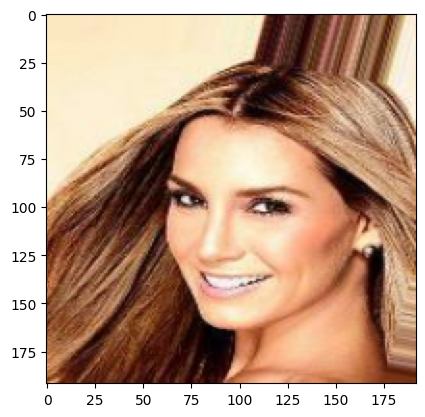

In [24]:
for image, attributes in labeled_images.take(1):
    plt.imshow(image)
    plt.show()

Ya que hemos hecho el pre procesamiento de los datos, comenzamos a construir un modelo que sea capaz de identificar las etiquetas asociadas a las imágenes del conjunto.

Primero, podemos ver la cantidad de imágenes que están en el dataset.

In [25]:
image_count = len(labeled_images)

image_count

202599

Ahora, podemos definir un tamaño de batch, que en este caso será `batch_size = 200` y además, vamos a establecer que el tamaño del conjunto de datos de entrenamiento sea del `90%` del total de imágenes.

In [26]:
batch_size = 200

train_size = int(image_count * 0.8)

Con `take()` indicamos que tome el tamaño del conjunto de entrenamiento definido en la celda anterior. El resto de imágenes serán el conjunto de datos de validación, lo indicamos con `skip()`.

In [27]:
train = labeled_images.take(train_size)

val = labeled_images.skip(train_size)

De acuerdo a los tutoriales proporcionados por TensorFlow y Keras, cuando tenemos un gran número de datos de entrenamiento, es bueno ayudar a que la computadora tenga un mejor desempeño al momento de procesarlos. Esto se puede lograr fácilmente haciendo uso de la utilidad `AUTOTUNE`. Definimos una función que configurará la red para mejorar el rendimiento, y dentro de ella barajeamos los datos, asignamos un tamaño de batch, y pedimos que el modelo vaya procesando los siguientes datos a entrenar mientras se encuentra en el paso de entrenamiento, esto con la finalidad de que no tarde mucho en ir tomando los datos del disco, y el tiempo de entrenamiento se reduzca.

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(dataset):
    dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size = AUTOTUNE)
    return dataset

Aplicamos estas configuraciones de rendimiento en los datos de entrenamiento y validación.

In [29]:
train = configure_for_performance(train)

val = configure_for_performance(val)

Ahora, recordemos que tenemos 40 etiquetas asociadas a cada una de las imágenes. Almacenamos esta información en la siguiente variable.

In [30]:
num_classes = 40

Podemos definir un modelo de capas secuencial, utilizando `tf.keras.Sequential()`. La arquitectura de red seleccionada consiste en una red neuronal con:

- 1 Capa de entrada de `shape = ((192,192,3))`.
- 6 Capas ocultas intermedias convolucionales Conv2D de 32 filtros, con tamaño de kernel igual a 3 y con función de activación `ReLU`.
- 6 Capas ocultas de MaxPooling2D asociadas a sus capas convolucionales.
- 1 Capa Flatten (aplanamiento) después de las Conv2D y sus MaxPooling.
- 1 Capa Dense de 128 neuronas y función de activación `Sigmoid`.
- 1 Capa de salida Dense con 40 neuronas de salida (una para cada etiqueta)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Input((192, 192, 3)),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'), 
    tf.keras.layers.MaxPooling2D(), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(num_classes)
])

En cuanto a la compilación del modelo, se intentaron varias configuraciones.

In [32]:
model.compile(
    optimizer = 'sgd',
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = tf.keras.metrics.BinaryAccuracy()
)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 95, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 93, 93, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 32)      

Las siguientes celdas son opcionales para ejecutar una sesión en Tensorboard y llevar un registro del entrenamiento del modelo.

In [34]:
#%load_ext tensorboard

In [35]:
#import datetime

In [36]:
#log_dir = 'logs_2/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

Entrenamos el modelo durante 30 épocas.

In [37]:
history = model.fit(
    train,
    validation_data = val,
    epochs = 30,
    #callbacks =  [tensorboard_callback]
)

Epoch 1/30
811/811 [==============================] - 350s 426ms/step - loss: 0.1509 - binary_accuracy: 0.8013 - val_loss: 0.1365 - val_binary_accuracy: 0.8034
Epoch 2/30
811/811 [==============================] - 347s 428ms/step - loss: 0.1360 - binary_accuracy: 0.8057 - val_loss: 0.1365 - val_binary_accuracy: 0.8034
Epoch 3/30
811/811 [==============================] - 238s 292ms/step - loss: 0.1359 - binary_accuracy: 0.8057 - val_loss: 0.1365 - val_binary_accuracy: 0.8034
Epoch 4/30
811/811 [==============================] - 208s 256ms/step - loss: 0.1359 - binary_accuracy: 0.8057 - val_loss: 0.1364 - val_binary_accuracy: 0.8034
Epoch 5/30
811/811 [==============================] - 212s 260ms/step - loss: 0.1359 - binary_accuracy: 0.8057 - val_loss: 0.1364 - val_binary_accuracy: 0.8034
Epoch 6/30
811/811 [==============================] - 211s 260ms/step - loss: 0.1359 - binary_accuracy: 0.8057 - val_loss: 0.1364 - val_binary_accuracy: 0.8034
Epoch 7/30
811/811 [====================

Guardamos el mejor modelo obtenido, que corresponde a la segunda corrida. (Las otras configuraciones se explican en el reporte.

In [38]:
#model.save('second_run.h5')

Hasta aquí concluye la primera parte del proyecto. Resta aplicar el siguiente paso de la metodología del Transfer Learning para poder utilizar los pesos aprendidos del modelo anterior sobre un nuevo conjunto de datos, sólo que en esta ocasión, la tarea consiste en determinar si un dato de entrada corresponde a una imagen de mi rostro.

Primero definimos algunas variables para nuestro nuevo modelo, el tamaño del batch y las dimensiones que deseamos tengan nuestras imágenes.


In [39]:
batch_size = 16

img_height = 192
img_width = 192

Ahora, creamos las rutas para los conjuntos de datos que vamos a utilizar. Note que estas rutas son relativas, así que deben de cambiarse a la ruta de archivos del directorio de trabajo propio.

In [40]:
photos_path_train = 'fotos/train'

photos_path_val = 'fotos/validation/'

photos_pat_test = 'fotos/test/'

Utilizando `tf.keras.preprocessing.image.ImageDataGenerator()` es posible realizar `Data augmentation` para incrementar sintéticamente el número de datos de entrenamiento. Y más aún, con `keras.flow_from_directory()` podemos generar un objeto que nuestro modelo va a poder reconocer como entrada.

In [41]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    rotation_range = 5,
    horizontal_flip = True
)

train_ds = train_gen.flow_from_directory(
    photos_path_train,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 112 images belonging to 2 classes.


Repetimos los pasos anteriores para los conjuntos de validación y test, sin hacer data augmentation.

In [42]:
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

val_ds = val_gen.flow_from_directory(
    photos_path_val,
    target_size = (img_width, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 39 images belonging to 2 classes.


In [43]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_ds = test_gen.flow_from_directory(
    photos_pat_test,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 6 images belonging to 1 classes.


Cargamos el modelo ganador del pre entrenamiento sobre CelebA.

In [44]:
winner_model = tf.keras.models.load_model('second_run.h5')

Y definimos un nuevo modelo secuencial, que contenga las capas convolucionales del modelo ganador y poniendo hasta el final dos capas densas de clasificación.

In [45]:
final_model = tf.keras.Sequential()
final_model.add(keras.layers.Input((192, 192, 3)))
final_model.add(winner_model.layers[0])
final_model.add(winner_model.layers[1])
final_model.add(winner_model.layers[2])
final_model.add(winner_model.layers[3])
final_model.add(winner_model.layers[4])
final_model.add(winner_model.layers[5])
final_model.add(winner_model.layers[6])
final_model.add(winner_model.layers[7])
final_model.add(winner_model.layers[8])
final_model.add(winner_model.layers[9])
final_model.add(winner_model.layers[10])
final_model.add(winner_model.layers[11])
final_model.add(winner_model.layers[12])
final_model.add(tf.keras.layers.Dense(128, activation = 'sigmoid'))
final_model.add(tf.keras.layers.Dense(1, activation = 'linear'))

Un paso fundamental en el Transfer Learning es el congelar los pesos que aprendieron las capas convolucionales. Afortunadamente es fácil pedirle a TensorFlow que no entrene ciertas capas específicas. Aquí le pedimos que únicamente entrene a las dos capas de clasificación que añadimos al final.

In [46]:
for layer in final_model.layers[:-2]:
    layer.trainable = False

Imprimimos el resumen de nuestro nuevo modelo. Notemos que el número de parámetros entrenables es mucho menor comparado al modelo ganador.

In [47]:
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 32)      

Compilamos el modelo recién creado, con los mismos parámetros que el del modelo ganador, excepto que modificamos un poco el `learning_rate` del optimizador.

In [48]:
final_model.compile(
    tf.keras.optimizers.SGD(learning_rate = 0.00001),
     loss = tf.keras.losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.BinaryAccuracy()]
      )

Finalmente, entrenamos durante 150 épocas, observamos los resultados y guardamos el modelo.

In [49]:
final_model.fit(train_ds,
validation_data = val_ds,
epochs = 150,
#callbacks = [tensorboard_callback]
)

Epoch 1/150
7/7 [==============================] - 3s 343ms/step - loss: 2.6028 - binary_accuracy: 0.4643 - val_loss: 2.4462 - val_binary_accuracy: 0.5128
Epoch 2/150
7/7 [==============================] - 2s 341ms/step - loss: 2.5795 - binary_accuracy: 0.4643 - val_loss: 2.4252 - val_binary_accuracy: 0.5128
Epoch 3/150
7/7 [==============================] - 2s 320ms/step - loss: 2.5584 - binary_accuracy: 0.4643 - val_loss: 2.4044 - val_binary_accuracy: 0.5128
Epoch 4/150
7/7 [==============================] - 2s 336ms/step - loss: 2.5384 - binary_accuracy: 0.4643 - val_loss: 2.3839 - val_binary_accuracy: 0.5128
Epoch 5/150
7/7 [==============================] - 2s 337ms/step - loss: 2.5168 - binary_accuracy: 0.4643 - val_loss: 2.3635 - val_binary_accuracy: 0.5128
Epoch 6/150
7/7 [==============================] - 2s 344ms/step - loss: 2.4964 - binary_accuracy: 0.4643 - val_loss: 2.3433 - val_binary_accuracy: 0.5128
Epoch 7/150
7/7 [==============================] - 2s 310ms/step - los

In [50]:
#final_model.save('modelo_final_reconocimiento_3.h5')

Un análisis un poco más detallado sobre los resultados obtenidos puede encontrarse en el reporte del proyecto.